# [DRAFT] combine fmask with ard then apply wofs <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments

## Background
It can be useful open an external raster dataset that you have previously saved to GeoTIFF or NetCDF into a Jupyter notebook in order to conduct further analysis or combine it with other Digital Earth Australia (DEA) data. 
In this example, we will demonstrate how to load in one or multiple GeoTIFF or NetCDF files originally exported to files from a Landsat-8 time-series into an `xarray.Dataset` for further analysis.

For advice on exporting raster data, refer to the [Exporting GeoTIFFs](../How_to_guides/Exporting_GeoTIFFs.ipynb) notebook.

For more information on the `xarray` and `rioxarray` functions used:

* `rioxarray.open_rasterio` (https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray-open-rasterio)
* `xarray.open_dataset` (http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)
* `xarray.open_mfdataset` (http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html)

## Description
This notebook shows how to open raster data from file using `xarray`'s built-in fuctions for handling GeoTIFF and NetCDF files:

1. Opening single raster files
    * Opening a single GeoTIFF file
    * Opening a single NetCDF file
2. Opening multiple raster files as an `xarray.Dataset` with a time dimension
    * Opening multiple GeoTIFF files
    * Opening multiple NetCDF files
    
    
1. find the fmask output
2. open and convert to xarray
3. clip to area of interest (we are on 4 cores here)
3. get corresponding ard from datacube. get xarray, clip to area of interest.
4. combine the two arrays to get one full dataset. 
5. apply wofs to see what happens.
is it better or worse, which way to go

***

## Getting started
 To run this example, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [14]:
%matplotlib inline

import glob
import xarray as xr
import rioxarray
import datacube
import rasterio.crs
from datetime import datetime, timedelta
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.geometry import Geometry, CRS
from odc.ui import with_ui_cbk
# from wofs.wofls import woffles_ard

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import paths_to_datetimeindex, load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import rgb, plot_wo
from dea_tools.temporal import time_buffer
from dea_tools.spatial import xr_rasterize
from dea_tools.dask import create_local_dask_cluster

# local copies
sys.path.insert(1, "../Applying WOfS to S2/wofs-1.6.5/")
from wofs.wofls import woffles_ard


## Opening a single raster file


### Define file paths
In the code below we define the locations of the GeoTIFF files that we will open. These were created when testing fmask parameters on S2 imagery. The fmask output is a classified layer with 5 classes.

In [15]:
sys.path.insert(1, '../dev/dea-notebooks/')
geotiff_path = '../S2_WO_Quality_Testing/Fmask_Outputs/testparallax_fmask.tif'

### Open the new Fmask layer

To open a geotiff we use `rioxarray.open_rasterio()` function which is built around the `rasterio` Python package.
When dealing with extremely large rasters, this function can be used to load data as a Dask array by providing a `chunks` parameter (e.g. `chunks={'x': 1000, 'y': 1000}`). This can be useful to reduce memory usage by only loading the specific portion of the raster you are interested in.

In [16]:
# Open into an xarray.DataArray
geotiff_da = rioxarray.open_rasterio(geotiff_path)

# Covert our xarray.DataArray into a xarray.Dataset
geotiff_ds = geotiff_da.to_dataset('band')

# Rename the variable to a more useful name
geotiff_ds = geotiff_ds.rename({1: 'oa_fmask'})
geotiff_ds


<xarray.Dataset>
Dimensions:      (y: 5490, x: 5490)
Coordinates:
  * x            (x) float64 2e+05 2e+05 2e+05 ... 3.097e+05 3.098e+05 3.098e+05
  * y            (y) float64 6.2e+06 6.2e+06 6.2e+06 ... 6.09e+06 6.09e+06
    spatial_ref  int64 0
Data variables:
    newfmask     (y, x) uint8 ...
Attributes: (12/17)
    LAYER_TYPE:                   thematic
    STATISTICS_COVARIANCES:       3.833151979183936
    STATISTICS_EXCLUDEDVALUES:    
    STATISTICS_HISTOBINFUNCTION:  direct
    STATISTICS_HISTOBINVALUES:    0|14106157|465218|827779|99874|14569428|0|0...
    STATISTICS_MAXIMUM:           5
    ...                           ...
    STATISTICS_SKIPFACTORY:       1
    STATISTICS_STDDEV:            1.9578437065261
    _FillValue:                   0
    scale_factor:                 1.0
    add_offset:                   0.0
    long_name:                    Layer_1

## clip fmask to area of interest

In [17]:
vector_file = '../S2_WO_Quality_Testing/Sample_Sites/Adelaide.geojson'
attribute_col = 'ID'
gdf = gpd.read_file(vector_file)
gdf.head()

,ID,geometry
0,Adelaide,"POLYGON ((138.02936 -34.50713, 138.02936 -35.3..."


In [18]:
gdf.explore(column=[2])

In [19]:
# clip to study area
# Dictionary to save results 
fmaskres = {}

# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():
    
    print(f'Feature: {index + 1}/{len(gdf)}')

    # load only the fmask layer and clip it to the polygon shape.

   # query = loadquery(products, time_of_interest, time_buff, measurements, resolution, align, gdf)
    
    # Load fmask layer
    geotiff_ds

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], geotiff_ds, crs='EPSG:3577')
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    geotiff_ds = geotiff_ds.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    fmaskres.update({str(row[attribute_col]): geotiff_ds})

Feature: 1/1


We can plot the data to verify it loaded correctly:

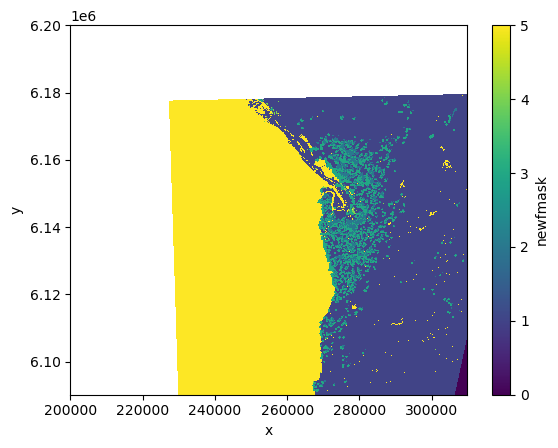

In [21]:
# check output
geotiff_ds.newfmask.plot()
# dir(geotiff_ds)

## Load corresponding S2 ARD, without the fmask layer and clip to same area
bring this in from the datacube. find the right date and granule. convert to xarray. join arrays.

In [5]:
dc = datacube.Datacube(app='Cloud_Masking_fromfmask')
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/yukie.nip@ga.gov.au/proxy/8787/status,
Dashboard: /user/yukie.nip@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 3,Total memory: 28.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38323,Workers: 1
Dashboard: /user/yukie.nip@ga.gov.au/proxy/8787/status,Total threads: 3
Started: Just now,Total memory: 28.21 GiB
Comm: tcp://127.0.0.1:42609,Total threads: 3
Dashboard: /user/yukie.nip@ga.gov.au/proxy/38977/status,Memory: 28.21 GiB
Nanny: tcp://127.0.0.1:39255,


In [6]:
# Fixed parameters
products = ["ga_s2am_ard_3", "ga_s2bm_ard_3"]
# don't need red edge, not concerned about vegetation.
measurements = ["nbart_coastal_aerosol", "nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3"]
resolution = (-10, 10)
output_crs = "EPSG:3577"
align = (5, 5) # check this
maturity = "final" 


In [22]:
# Dynamic Parameters - don't bother with time buffer if you know which date the images were captured.
time_of_interest = '2023-04-24'
time_buff = '1 days'

In [25]:
# Find matching datasets    
def loadquery(products, time_of_interest, time_buff, measurements, resolution, align, gdf):
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
         
    dss = dc.find_datasets(product=products, time=time_of_interest, geopolygon=geom)
    # Identify native CRS from datasets; fall back on "EPSG:3577"    # if no data is found to prevent an error    
    native_crs = dss[0].crs if len(dss) > 0 else "EPSG:3577"

    query = {'time': time_buffer(time_of_interest, buffer=time_buff),
             'measurements': measurements,
             'resolution': resolution,
             'output_crs': native_crs,
             'align': align,
             'group_by': 'solar_day',
             'dask_chunks':{}
             }

    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})                                            
                                              
    return query                                         


In [26]:
# Dictionary to save results 
results = {}

# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():
    
    print(f'Feature: {index + 1}/{len(gdf)}')
   
    query = loadquery(products, time_of_interest, time_buff, measurements, resolution, align, gdf)
    
    # Load Sentinel 2
    ds = dc.load(product=("ga_s2am_ard_3","ga_s2bm_ard_3"),
            progress_cbk=with_ui_cbk(),
            dataset_maturity="final",
            **query)
    #ds['fmask'] = ds['oa_fmask']

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    ds = ds.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({str(row[attribute_col]): ds})


Feature: 1/1


In [27]:
results

{'Adelaide': <xarray.Dataset>
 Dimensions:                (time: 1, y: 9922, x: 10583)
 Coordinates:
   * time                   (time) datetime64[ns] 2023-04-24T00:56:42.620059
   * y                      (y) float64 6.18e+06 6.18e+06 ... 6.081e+06 6.081e+06
   * x                      (x) float64 2.273e+05 2.273e+05 ... 3.331e+05
     spatial_ref            int32 32754
 Data variables:
     nbart_coastal_aerosol  (time, y, x) float32 dask.array<chunksize=(1, 9922, 10583), meta=np.ndarray>
     nbart_blue             (time, y, x) float32 dask.array<chunksize=(1, 9922, 10583), meta=np.ndarray>
     nbart_green            (time, y, x) float32 dask.array<chunksize=(1, 9922, 10583), meta=np.ndarray>
     nbart_red              (time, y, x) float32 dask.array<chunksize=(1, 9922, 10583), meta=np.ndarray>
     nbart_nir_1            (time, y, x) float32 dask.array<chunksize=(1, 9922, 10583), meta=np.ndarray>
     nbart_nir_2            (time, y, x) float32 dask.array<chunksize=(1, 9922, 1058

In [28]:
ds.isel(time=0)

<xarray.Dataset>
Dimensions:                (y: 9922, x: 10583)
Coordinates:
    time                   datetime64[ns] 2023-04-24T00:56:42.620059
  * y                      (y) float64 6.18e+06 6.18e+06 ... 6.081e+06 6.081e+06
  * x                      (x) float64 2.273e+05 2.273e+05 ... 3.331e+05
    spatial_ref            int32 32754
Data variables:
    nbart_coastal_aerosol  (y, x) float32 dask.array<chunksize=(9922, 10583), meta=np.ndarray>
    nbart_blue             (y, x) float32 dask.array<chunksize=(9922, 10583), meta=np.ndarray>
    nbart_green            (y, x) float32 dask.array<chunksize=(9922, 10583), meta=np.ndarray>
    nbart_red              (y, x) float32 dask.array<chunksize=(9922, 10583), meta=np.ndarray>
    nbart_nir_1            (y, x) float32 dask.array<chunksize=(9922, 10583), meta=np.ndarray>
    nbart_nir_2            (y, x) float32 dask.array<chunksize=(9922, 10583), meta=np.ndarray>
    nbart_swir_2           (y, x) float32 dask.array<chunksize=(9922, 10583), meta=np.ndarray>
    nbart_swir_3           (y, x) float32 dask.array<chunksize=(9922, 10583), meta=np.ndarray>
    oa_fmask               (y, x) float32 dask.array<chunksize=(9922, 10583), meta=np.ndarray>
Attributes:
    crs:           epsg:32754
    grid_mapping:  spatial_ref

In [29]:
key = 'Adelaide'

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


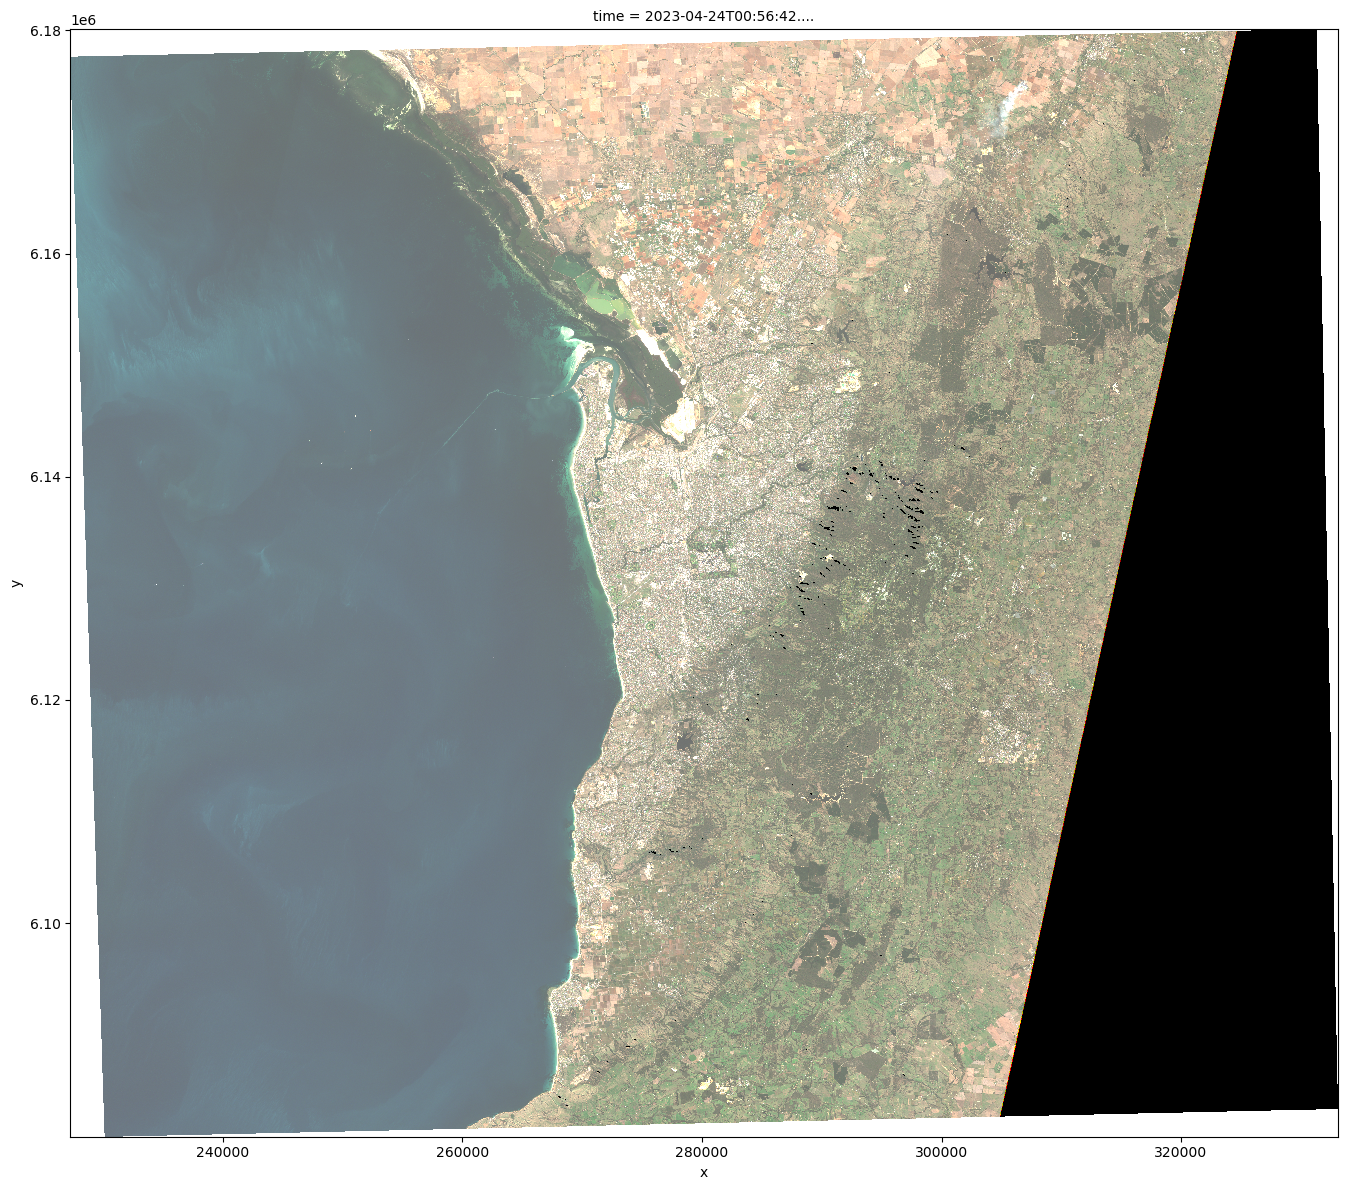

In [31]:
rgb(results[key], col='time', size=12)

## Combine into single xarray.Dataset

Geospatial time series data is commonly stored as multiple individual files with one time-step per file. 
These are difficult to use individually, so it can be useful to load multiple files into a single `xarray.Dataset` prior to analysis.
This also allows us to analyse data in a format that is directly compatible with data directly loaded from the Datacube.

### Multiple GeoTIFFs

To load multiple GeoTIFF files into a single `xarray.Dataset`, we first need to obtain a list of the files using the `glob` package.
In the example below, we return a list of any files that match the pattern `geotiff_*.tif`:

In [7]:
geotiff_list = glob.glob('../Supplementary_data/Opening_GeoTIFFs_NetCDFs/geotiff_*.tif')
geotiff_list

['../Supplementary_data/Opening_GeoTIFFs_NetCDFs/geotiff_red_2018-01-19.tif',
 '../Supplementary_data/Opening_GeoTIFFs_NetCDFs/geotiff_red_2018-03-24.tif',
 '../Supplementary_data/Opening_GeoTIFFs_NetCDFs/geotiff_red_2018-01-03.tif']

We now read these files using `xarray`. 
To ensure each raster is labelled correctly with its time, we can use the helper function `paths_to_datetimeindex()` from `dea_datahandling` to extract time information from the file paths we obtained above.
We then load and concatenate each dataset along the `time` dimension using `rioxarray.open_rasterio()`, convert the resulting `xarray.DataArray` to a `xarray.Dataset`, and give the variable a more useful name (`red`):


In [8]:
# this is the default from the notebook 
# Create variable used for time axis
time_var = xr.Variable('time', paths_to_datetimeindex(geotiff_list, 
                                                      string_slice=(12, -4)))

# Load in and concatenate all individual GeoTIFFs
geotiffs_da = xr.concat([rioxarray.open_rasterio(i) for i in geotiff_list], 
                        dim=time_var)

# Covert our xarray.DataArray into a xarray.Dataset
geotiffs_ds = geotiffs_da.to_dataset('band')

# Rename the variable to a more useful name
geotiffs_ds = geotiffs_ds.rename({1: 'red'})

# Print the output
print(geotiffs_ds)


<xarray.Dataset>
Dimensions:      (time: 3, y: 212, x: 191)
Coordinates:
  * x            (x) float64 2.053e+06 2.053e+06 ... 2.058e+06 2.058e+06
  * y            (y) float64 -3.307e+06 -3.307e+06 ... -3.313e+06 -3.313e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2018-01-19 2018-03-24 2018-01-03
Data variables:
    red          (time, y, x) int16 902 1307 931 416 544 ... 305 329 332 322 312
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0


To verify the data was loaded correctly, we can plot it using `xarray`:

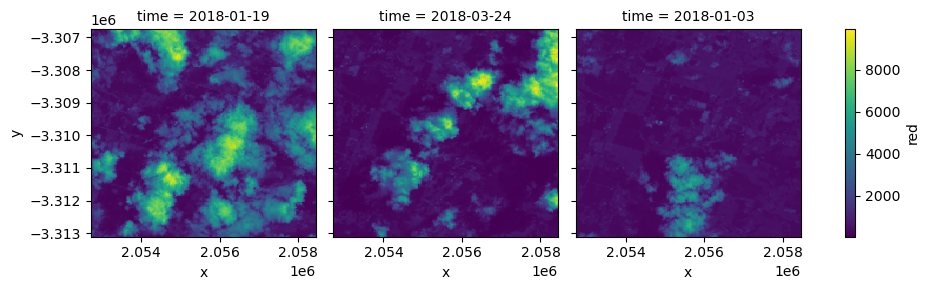

In [9]:
geotiffs_ds.red.plot(col='time')

## Apply WOfS
compare the different fmask -> wofs outputs. give name fmask_default and fmask, then swap out the names when running wofs to call the one you want.
pixel comparison by doing raster maths subtraction. the values will be dependent on the bit classification, so create a new legend because the bit subtraction will work. write everything out and see what happens. 

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)